In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import json
import cv2
import torch
import sys
# allows this notebook access to all files and folders in this project
sys.path.insert(0, r'C:\Users\Nikolaj\OneDrive - Danmarks Tekniske Universitet\DTU\Kandidat\MasterThesis\Code\MasterThesis')
from Core.DataLoader import GoalCalibrationDataset

datapath = r"C:\Users\Nikolaj\OneDrive - Danmarks Tekniske Universitet\DTU\Kandidat\MasterThesis\Code\MasterThesis\Data"

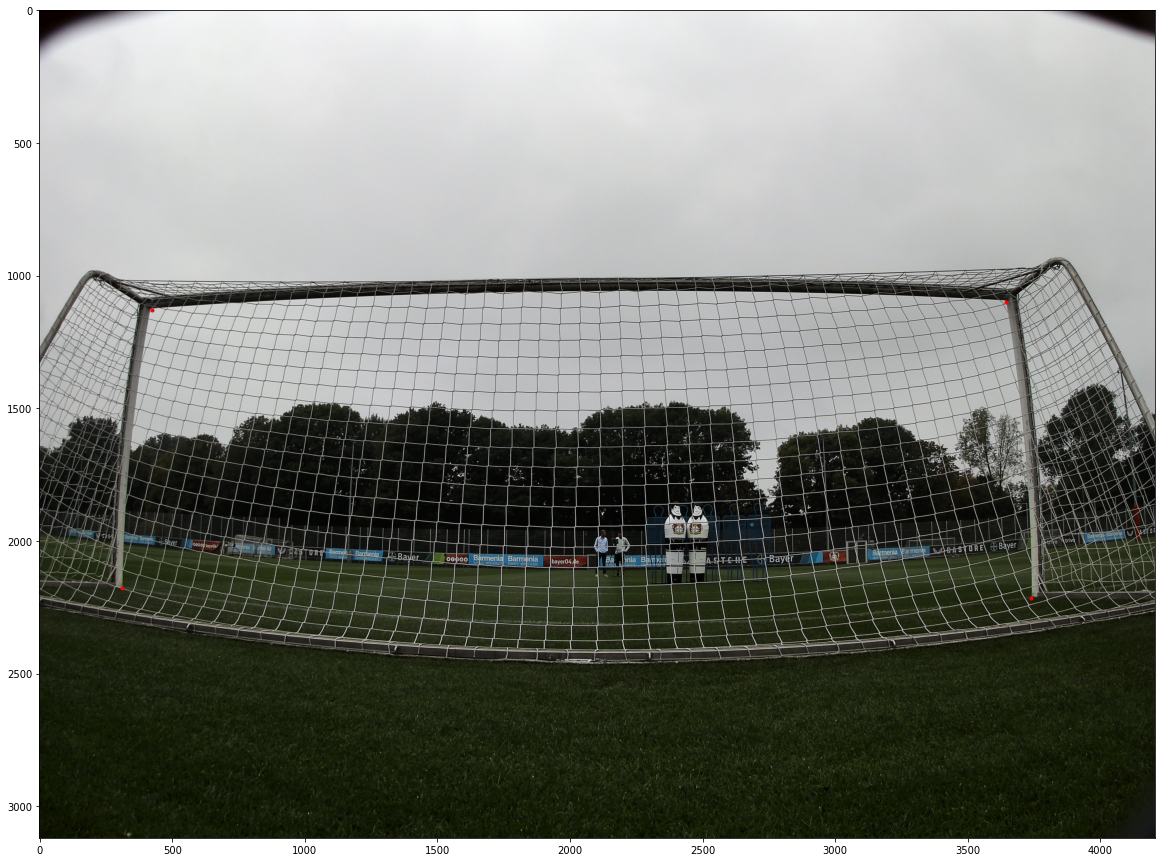

In [5]:
# initialize an instance of the dataloader
datasetclass = GoalCalibrationDataset(datapath)
# get an example of the data for plotting
img0,cal0 = datasetclass.__getitem__(10)
# plot the image and corresponding calibration points
_,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(img0.permute(1,2,0))
ax.plot(*cal0.T,'r.')

In [6]:
def gaussian1DKernel(sigma):
    h = np.maximum(np.ceil(5*sigma), 1)
    var = sigma**2
    x = np.arange(-h,h+1)
    g = 1/(np.sqrt(2*np.pi*var))*np.exp(-x**2/(2*var))
    gx = -x/var * g
    return g[:,None],gx[:,None]

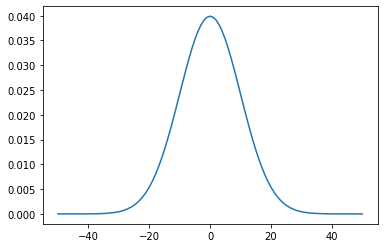

In [7]:
gtemp,gxtemp = gaussian1DKernel(10)
htemp = np.maximum(np.ceil(5*10), 1)
xtemp = np.arange(-htemp,htemp+1)
plt.plot(xtemp,gtemp)

In [8]:
def gaussian(img, pt, sigma):
    # Draw a 2D gaussian
    img = img/255
    # Check that any part of the gaussian is in-bounds
    ul = [int(pt[0] - 3 * sigma), int(pt[1] - 3 * sigma)]
    br = [int(pt[0] + 3 * sigma + 1), int(pt[1] + 3 * sigma + 1)]
    if (ul[0] > img.shape[1] or ul[1] >= img.shape[0] or
            br[0] < 0 or br[1] < 0):
        # If not, just return the image as is
        print('failed')
        return img

    # Generate gaussian
    size = 6 * sigma + 1
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    # The gaussian is not normalized, we want the center value to equal 1
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    print(f'g: {g.shape}\n{g}')
    print(f'max of g: {np.max(g)}')
    # Usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], img.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], img.shape[0]) - ul[1]
    # Image range
    img_x = max(0, ul[0]), min(br[0], img.shape[1])
    img_y = max(0, ul[1]), min(br[1], img.shape[0])
    
    print(f'g_x: {g_x}')
    print(f'g_y: {g_y}')
    print(f'center vals of g: {(g[g_y[0]:g_y[1], g_x[0]:g_x[1]]).shape}\n{g[g_y[0]:g_y[1], g_x[0]:g_x[1]]}')
    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    return img

In [9]:
img0.permute(1,2,0).shape

torch.Size([3120, 4208, 3])

In [10]:
cal0

tensor([[ 422.4843, 1129.7684],
        [3642.6531, 1098.5685],
        [ 312.4633, 2179.0737],
        [3739.5374, 2213.5579]])

In [11]:
img0.permute(1,2,0)[394:425,986:1017].shape

torch.Size([31, 31, 3])

In [12]:
img0gray = cv2.cvtColor(img0.permute(1,2,0).detach().cpu().numpy(),cv2.COLOR_BGR2GRAY)

In [13]:
heatmap = torch.from_numpy(gaussian(img0gray, cal0[0], 10))
heatmap.shape

g: (61, 61)
[[0.00012341 0.00016575 0.00022041 ... 0.00022041 0.00016575 0.00012341]
 [0.00016575 0.00022263 0.00029604 ... 0.00029604 0.00022263 0.00016575]
 [0.00022041 0.00029604 0.00039367 ... 0.00039367 0.00029604 0.00022041]
 ...
 [0.00022041 0.00029604 0.00039367 ... 0.00039367 0.00029604 0.00022041]
 [0.00016575 0.00022263 0.00029604 ... 0.00029604 0.00022263 0.00016575]
 [0.00012341 0.00016575 0.00022041 ... 0.00022041 0.00016575 0.00012341]]
max of g: 1.0
g_x: (0, 61)
g_y: (0, 61)
center vals of g: (61, 61)
[[0.00012341 0.00016575 0.00022041 ... 0.00022041 0.00016575 0.00012341]
 [0.00016575 0.00022263 0.00029604 ... 0.00029604 0.00022263 0.00016575]
 [0.00022041 0.00029604 0.00039367 ... 0.00039367 0.00029604 0.00022041]
 ...
 [0.00022041 0.00029604 0.00039367 ... 0.00039367 0.00029604 0.00022041]
 [0.00016575 0.00022263 0.00029604 ... 0.00029604 0.00022263 0.00016575]
 [0.00012341 0.00016575 0.00022041 ... 0.00022041 0.00016575 0.00012341]]


torch.Size([3120, 4208])

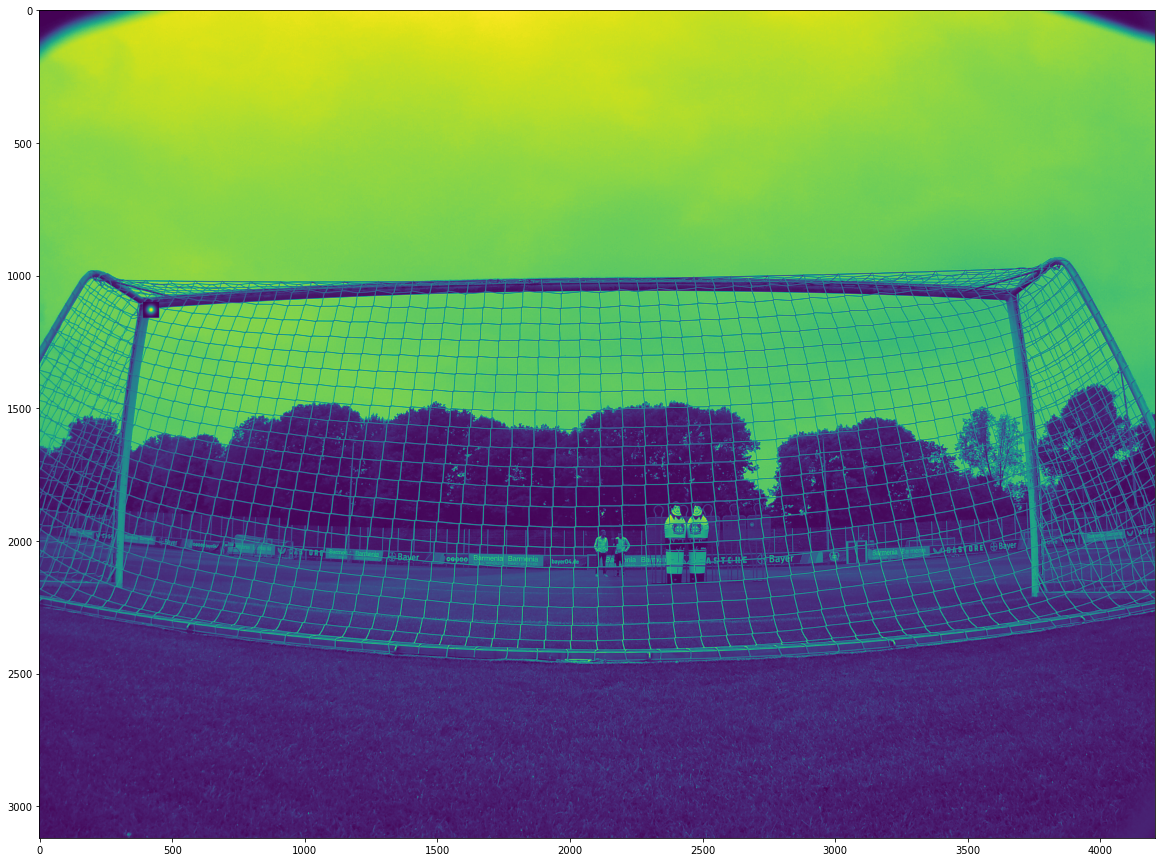

In [14]:
_,ax = plt.subplots(1,1,figsize=(20,20))
ax.imshow(heatmap)

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

gaussian filter of 100 X 100 :
max value of gaussian: 0.9998979747998641


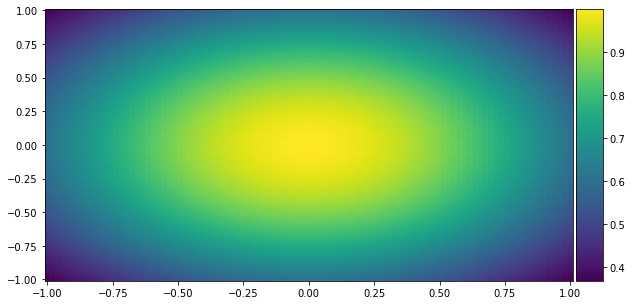

In [7]:
# Importing Numpy package
import numpy as np
 
# sigma(standard deviation) and muu(mean) are the parameters of gaussian

def gaussian_filter(kernel_size, sigma=1, muu=0):
 
    # Initializing value of x,y as grid of kernel size
    # in the range of kernel size
    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),np.linspace(-1, 1, kernel_size))
    dst = np.sqrt(x**2+y**2)
    # Calculating Gaussian filter
    gauss = np.exp(-((dst-muu)**2 / (2.0 * sigma**2)))
    return gauss,x,y

kernel_size=100
gaussian,xp,yp = gaussian_filter(kernel_size)
print("gaussian filter of {} X {} :".format(kernel_size,kernel_size))
print(f'max value of gaussian: {np.max(gaussian)}')

# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

im = ax.pcolormesh(xp,yp, gaussian, shading='auto')
ax.grid(False)
add_colorbar(im, fig, ax)